# Music Genre Recognition with Keras Tensorflow

## Introduction to Audio Data

Audio is a form of vibration that produced sound. Humans generate sounds with the vocal cords that attached within the larynx to the Adam's apple. The vocal cords produce sound when they come together and then vibrate as air passes through them during exhalation of air from the lungs. Sounds can also produced by objects with the same concepts as the human one. The vibrations of sound determines oscillation of air molecules which create alternation of air pressures that causing a wave. This waveform will be the first shape we will look later before we doing data preprocessing.

Audio that get recorded digitally is an unstructured data that has attributes like frequency, amplitude, etc. that we will used to gain information inside it. We will need to extract them from the waveform shape until we can process further. This will be covered on each step later. We will use music genre dataset on this project from [here](http://marsyas.info/downloads/datasets.html). The data is composed by ten music genres with 100 data on each genre, but we will only use 5 genres the total of 10 genres. From each genres we will use 90 of the data for training and another 10 for predict data. I will pick blues, classical, country, disco, and hiphop because they are the first 5 category based on ascending alphabet.

## Import Library 

In [1]:
import tensorflow
tensorflow.__version__

'2.7.0'

In [59]:
# base library
import json
import os
import math

# exploratory data
import pandas as pd
import numpy as np
from collections import Counter
import librosa, librosa.display
import matplotlib.pyplot as plt

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras as keras
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

# set seed
import random
random.seed(222)
np.random.seed(222)
tensorflow.random.set_seed(222)

## Exploratory Data

### Raw Shape of Audio Data

Here we will look at the shape of our audio data. We will need to use an audio library analysis called librosa to process it. Extracting with librosa will provide our data shape as a waveform. We will also have to determine the sample rate of our data, which is provided when we download it (22050 Hz). **Sample rate** is the number of audio samples per second. If we compare it with image data, it is a bit similar with pixels. The higher pixel the better image produced. While here in audio data, the higher sample rate the smoother a sound is, so the audio quality get better. 

Text(0.5, 1.0, 'Waveform')

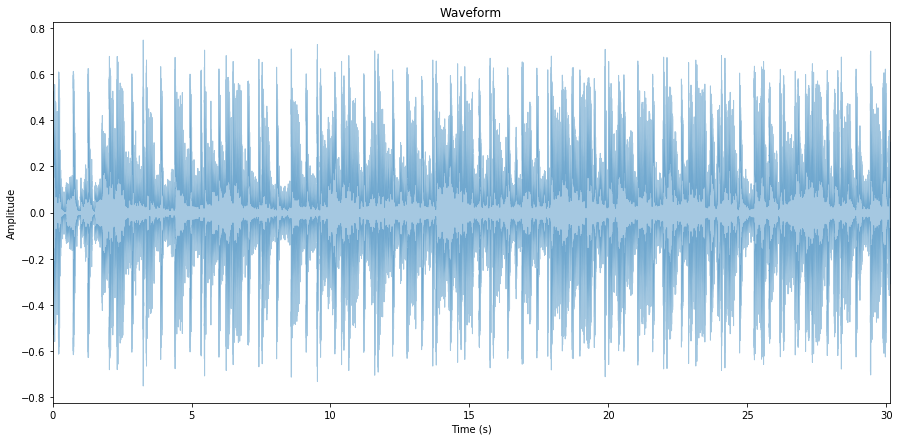

In [3]:
FIG_SIZE = (15,7)
PATH = "data/genres-select/"
FILE_PATH = PATH + "disco/disco.00000.wav"

# load audio file with Librosa
signal, sample_rate = librosa.load(FILE_PATH, sr=22050)

# display waveform
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(signal, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

If we look closely we will find that the waveform shows a sine wave that have an amplitudes changes based on time. The clear and closer animation should be like this: <br>
<img src="assets/sound-direction-of-sound-waves-01.png" width=600 align='right' /> <br>
When we talk about wave we will always discuss about frequency and period. A **period** (T) of wave is a condition when a cycle of wave achieved, like the 'wavelength' showed by the picture (from crest to crest or trough to trough). While **frequency** is another approach to see the sound wave that can't be showed by time domain like on the picture, but we can say that the frequency and wave period are inversely proportional to each other. If the frequency increases, the period decreases, and vice-versa. 
The higher the frequency (or the lower the period) means the higher the pitch of a sound. The other elements of sound that we can see from the picture is amplitude. Amplitudes tells the loud of a sound, so a higher amplitude means the more loud our sound.

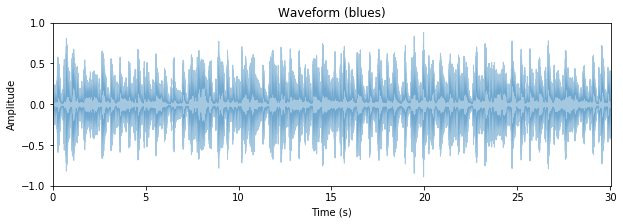

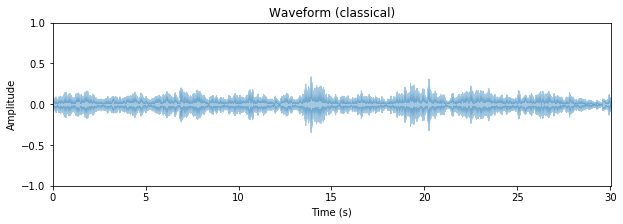

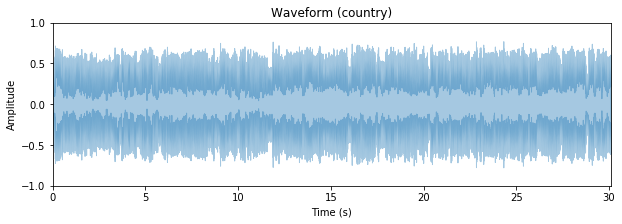

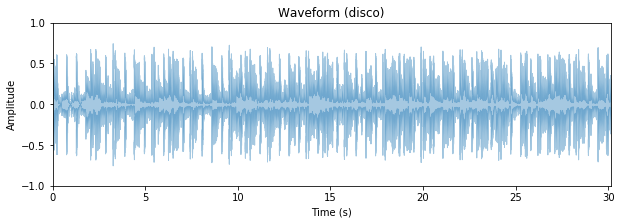

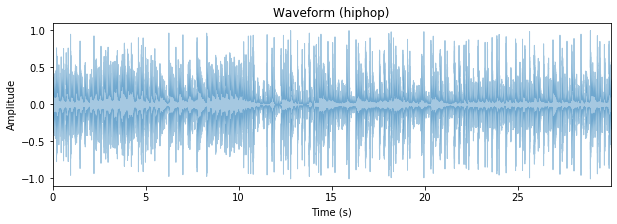

In [83]:
FIG_SIZE_L = (10,15)
PATH_L = "data/genres-select/"
files =  ["blues/blues.00000.wav", "classical/classical.00000.wav", "country/country.00000.wav",
          "disco/disco.00000.wav", "hiphop/hiphop.00000.wav"]

for item in files:
    FILE_PATH_L = PATH_L + item
    # load audio file with Librosa
    signal, sample_rate = librosa.load(FILE_PATH_L, sr=22050)
    
    # display waveform
    plt.figure(figsize=(10, 3))
    librosa.display.waveplot(signal, sample_rate, alpha=0.4)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.yticks(np.arange(-1, 1.25, 0.5))
    plt.title(f"Waveform ({item.split(sep='/')[0]})")

### Fast Fourier Transform (FFT) 

<img src="assets/xGYxh.jpg" width=400 align='right' />

From the waveform visualization above, we can see the difference of pattern and amplitude from each genres. We can see that classical music has the lowest amplitude from other genres, and country has a more constant pattern of its waveform. Other than that we can't really get anything else from our waveform visualization. <br>

So the next step will be to change our data from time domain to frequency domain. We will use Fast Fourier Transform (FFT) to do this. Fourier transform decompose our complex periodic sounds into sum of sine waves that oscillating at different frequencies, because the waveform of sounds that we saw above are composed by superposition of waves with different frequencies. The picture on the left show what FFT does to our data. After FFT process, we will not see our sounds as waveform shape anymore, it will be shown as power spectrum. 


Text(0.5, 1.0, 'Power spectrum')

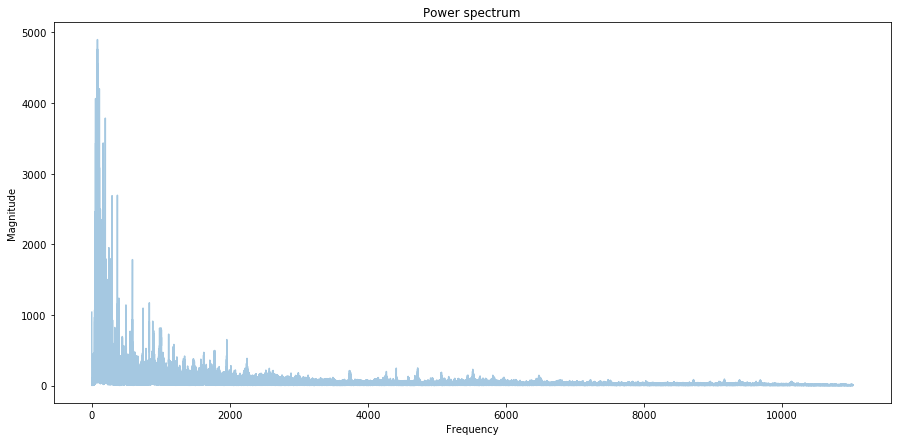

In [5]:
# FFT -> power spectrum
# perform Fourier transform
fft = np.fft.fft(signal)

# calculate absolute values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

### Short-time Fourier Transform
Since we moved from time domain to frequency domain, we will lose information about time on our plot. So we can say that the plot is a snapshot of all frequencies that happened on 30 seconds of our song. And because things are changing between time on songs, we want to keep this time information on our FFT process. The method to do that is using Short-time Fourier Transform (STFT). STFT will make our FFT happened on separate windows and make segmentations on our waveform shape data. With STFT we can perserve our time information even after we use FFT.

In [6]:
# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {} second".format(hop_length_duration))
print("STFT window duration is: {} second".format(n_fft_duration))

STFT hop length duration is: 0.023219954648526078 second
STFT window duration is: 0.09287981859410431 second


Text(0.5, 1.0, 'Spectrogram')

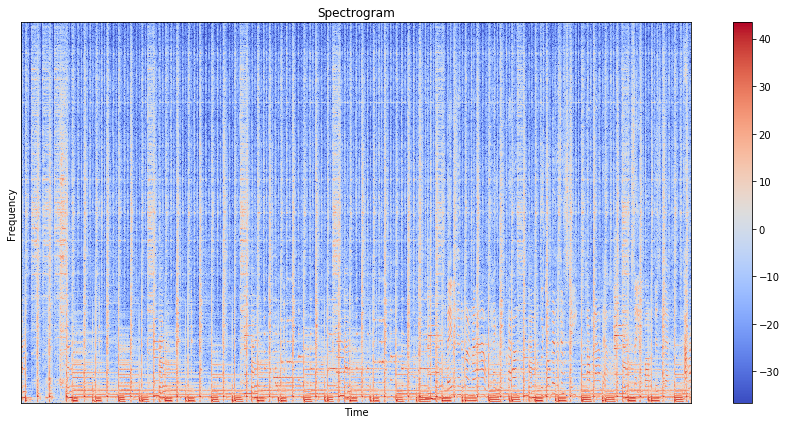

In [7]:
# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate absolute values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

### Mel Frequency Cepstral Coefficents (MFCCs)
Then what should we do with our data after we make a segmentation fourier transform or STFT? After that we need to get the feature from our data before processing them on our machine learning algorithm. That will happen with MFCCs process. MFCCs is a method for extracting sound feature. It captures the timbral aspects of sound and approximate how human perceive sound with number.

The input for MFCCs by librosa are the signal and sample rate that generated by librosa.load then it will instantly converting our data to frequency domain from time domain with segmentation to preserve our time information. The process before we extracting features in MFCCs includes the process of what we have done above, so we will need some of our arguments that we have defined before.

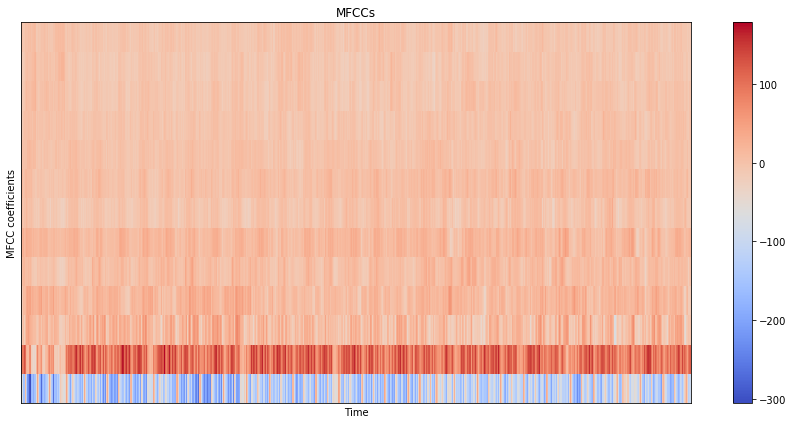

In [8]:
# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()

Those above are the whole preprocessing step that will be used later when we prepare our data. Well, later we will only use MFCC from librosa after we load the waveform data since the function already cover STFT process and other things.

## Data Preprocessing

In this section we will build a function to read dataset then convert them using MFCC method from librosa then saving the output to a json file. This json file will be the data that we use later when we read data. Each music data that we are going to predict will be separated since the duration of each one is about 30 second. At the end we will have total initial data multiplied by our number of segments so the total data will be change in this process. But don't worry, on the prediction section we will cover how to make it back and have a prediction for each music data and not their segments.

In [9]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
    
    --Arguments--
        dataset_path: str 
            Path to dataset
        json_path: str 
            Path to json file used to save MFCCs
        num_mfcc: int 
            Number of coefficients to extract
        n_fft: int
            Interval we consider to apply FFT. Measured in # of samples
        hop_length: int
            Sliding window for FFT. Measured in # of samples
        num_segments: int 
            Number of segments we want to divide sample tracks into
        
    """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("\\")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, 
                                                n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        

In [10]:
DATASET_PATH = "data/genres-select"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

### Load Training Dataset
The function in this sub section is for loading our json data and make it to numpy array format that will be our model input later.

In [62]:
def load_data(data_path):
    """Loads training dataset from json file.
        
    --Arguments--
        data_path: str 
            Path to json file containing data
            
    --Returns--
        X: ndarray
            Inputs
        y: ndarray
            Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return X, y

In [63]:
# from google.colab import drive
# drive.mount('/content/drive')

In [64]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "data.json" # using local file
# DATA_PATH = "/content/drive/MyDrive/DSS2/data.json" # using google colab

# load data
X, y = load_data(DATA_PATH)
# y.replace({0:'blues', 1:'classical', 2:'country', 3:'disco', 4:'hiphop'})

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)

Data succesfully loaded!
Train data shape:  (3597, 130, 13)


## Setting CNN Architecture

On this case we are going to train a Convolutional Neural Network (CNN) model to classify our music genres. CNN is mainly used for processing image data to extract different features from them. Since our mfcc data have a shape like 2 dimensional data we can use the same approach to process our data. If you look on the visualization on MFCC section, we have x axis of time, y axis of MFCC coefficients, and pixel value which indicate our values.
Thus in this section we will build a 2 dimensional CNN architecture with a function. CNN will effectively uses the adjacent pixel to downsample the MFCC features and then use a fully-connected layer to solve the classification problem. Other than Convolution and Pooling step, we will also add Batch Normalization process for each convolution layer. The purpose of this Batch Normalization is to speed up learning and reduce overfitting.


In [65]:
def build_model2D(input_shape):
    """Generates CNN model
        
    --Arguments--
    input_shape: tuple 
        Shape of input set
            
    --Returns--
    model: 
        CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(units=5, activation='softmax'))

    return model

## Training Model

After we make the model architecture, we are going to train our model using data train. We are going to use Adam as optimizers and calculating loss with sparse categorical cross entropy. Also because we are using a balanced class data (same amount of data from each class) we will use accuracy as metrics. At fitting process we will save the best model based on validation loss value.

In [67]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1) # 2D model
model = build_model2D(input_shape)

# compile model
optim = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 6, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 64, 6, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 31, 2, 32)        0         
 g2D)                                                            
                                                      

In [68]:
# save model
checkpoint = ModelCheckpoint('model/cnn_music_genre.hdf5',
                             verbose = 1,
                             save_best_only = True,
                             monitor='val_loss',
                             mode='min')

# train model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=32, 
                    epochs=30,
                    callbacks = [checkpoint],
                    verbose = 1)

Epoch 1/30
111/113 [============================>.] - ETA: 0s - loss: 1.6515 - accuracy: 0.3666
Epoch 00001: val_loss improved from inf to 1.43269, saving model to model\cnn_music_genre.hdf5
113/113 [==============================] - 4s 32ms/step - loss: 1.6479 - accuracy: 0.3670 - val_loss: 1.4327 - val_accuracy: 0.4256
Epoch 2/30
111/113 [============================>.] - ETA: 0s - loss: 1.1237 - accuracy: 0.5538
Epoch 00002: val_loss improved from 1.43269 to 0.91830, saving model to model\cnn_music_genre.hdf5
113/113 [==============================] - 4s 32ms/step - loss: 1.1241 - accuracy: 0.5541 - val_loss: 0.9183 - val_accuracy: 0.6356
Epoch 3/30
113/113 [==============================] - ETA: 0s - loss: 0.9491 - accuracy: 0.6186
Epoch 00003: val_loss improved from 0.91830 to 0.78143, saving model to model\cnn_music_genre.hdf5
113/113 [==============================] - 4s 32ms/step - loss: 0.9491 - accuracy: 0.6186 - val_loss: 0.7814 - val_accuracy: 0.6922
Epoch 4/30
111/113 [===

Epoch 27/30
111/113 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.8998
Epoch 00027: val_loss did not improve from 0.35971
113/113 [==============================] - 3s 31ms/step - loss: 0.2643 - accuracy: 0.8994 - val_loss: 0.3622 - val_accuracy: 0.8733
Epoch 28/30
111/113 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.9175
Epoch 00028: val_loss did not improve from 0.35971
113/113 [==============================] - 3s 31ms/step - loss: 0.2451 - accuracy: 0.9169 - val_loss: 0.3728 - val_accuracy: 0.8678
Epoch 29/30
111/113 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9136
Epoch 00029: val_loss did not improve from 0.35971
113/113 [==============================] - 3s 31ms/step - loss: 0.2433 - accuracy: 0.9121 - val_loss: 0.3703 - val_accuracy: 0.8622
Epoch 30/30
111/113 [============================>.] - ETA: 0s - loss: 0.2376 - accuracy: 0.9124
Epoch 00030: val_loss did not improve from 0.35971
113/113 [===

In [69]:
def plot_history(model_name):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        
    --Arguments--
        model_name: 
            Training history of model
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(model_name.history["accuracy"], label="train accuracy")
    axs[0].plot(model_name.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(model_name.history["loss"], label="train error")
    axs[1].plot(model_name.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
    plt.tight_layout()
    
    print("train accuracy: ", history.history["accuracy"][-1])
    print("validation accuracy: ", history.history["val_accuracy"][-1])

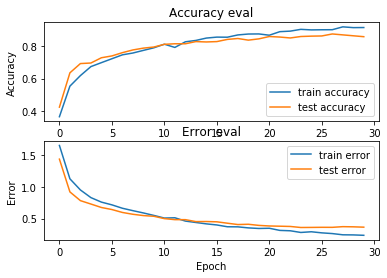

train accuracy:  0.9127050042152405
validation accuracy:  0.8566666841506958


<Figure size 432x288 with 0 Axes>

In [70]:
# plot accuracy and error as a function of the epochs
plot_history(history)

The result shows that our model is not overfitting. The train data accuracy is 91.2% while the validation data is 85.67%. With this result we can move into our next step which is testing our model to another music data and check its accuracy.

### Load Testing/Prediction Dataset
If you forget, I decide to left out 10 data from each class to be an unseen dataset that we will predict. This section will cover it up, starting with converting data to mfcc features, reading, then predicting data. We will evaluate our model with two different prediction. The first one will be using model.evaluate() from keras and the second one we will use manual model.predict() comparison with our target variable.

In [21]:
DATASET_PATH = "data/genres-test"
PREDICT_DATA_JSON = "predict_data.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

save_mfcc(DATASET_PATH, PREDICT_DATA_JSON, num_segments=10)

In [71]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PREDICT_PATH = "predict_data.json" # using local file
# DATA_PREDICT_PATH = "/content/drive/MyDrive/DSS2/predict_data.json" # using google colab

# load data
X_pred, y_pred = load_data(DATA_PREDICT_PATH)

Data succesfully loaded!


#### First prediction

In [72]:
best_model = keras.models.load_model("model/cnn_music_genre.hdf5")

In [78]:
# evaluate unseen data using function from keras
cnn_loss, cnn_accuracy = best_model.evaluate(X_pred, y_pred, batch_size=32)
print("Model loss: {}\nModel accuracy: {}".format(cnn_loss, cnn_accuracy))

16/16 [==============================] - 0s 9ms/step - loss: 0.8507 - accuracy: 0.7455
Model loss: 0.8506574034690857
Model accuracy: 0.7454909682273865


#### Second prediction
This second prediction is important because our data got segmented when we did data preprocessing step. Since each of our song data get segmented and become a total of `num_segments` of data, our model result will also be segmented and the predictions of a song will have a total of our observation multiplied by `num_segments`. Thus we use mode calculation and take class with dominant results from our prediction. With this we will get the same amount of prediction with our song input amount. 

In [79]:
def take_mode(result, num_segments=10):
    """Function to take mode value from num_segments of data
        
    --Arguments--
        result: 
            Result from model prediction
        num_segments:
            The segments that we defined when we save and convert data with mfcc
    """
    new_result = []
    i = 0
    
    for i in range(int((len(result)+1)/num_segments)):
        new_result.append(Counter(result[(i*num_segments):((i+1)*num_segments)].tolist()).most_common()[0][0])
        i += 1
        
    return new_result

In [80]:
# evaluate unseen data using manual method
pred = model.predict(X_pred, batch_size=32, verbose=1)

result = pred.argmax(axis=1)
new_result = take_mode(result)
y_pred_upd = take_mode(y_pred)

compare = pd.DataFrame({'prediction': new_result, 
                        'observation': y_pred_upd})

compare['comparison'] = np.where(compare['prediction'] == compare['observation'], True, False)

manual_accuracy = compare['comparison'].value_counts()[1]/len(new_result)
print("Manual accuracy calculation: {}".format(manual_accuracy))

16/16 [==============================] - 0s 9ms/step
Manual accuracy calculation: 0.82


In [81]:
print(compare['comparison'].value_counts())

True     41
False     9
Name: comparison, dtype: int64


In [82]:
# evaluate unseen data using manual method
pred = model.predict(X_pred, batch_size=32, verbose=1)

compare2 = pd.DataFrame({'prediction': result, 
                        'observation': y_pred})

compare2['comparison'] = np.where(compare2['prediction'] == compare2['observation'], True, False)

manual_accuracy2 = compare2['comparison'].value_counts()[1]/len(result)
print("Manual accuracy calculation: {}".format(manual_accuracy2))

16/16 [==============================] - 0s 10ms/step
Manual accuracy calculation: 0.7354709418837675


## Conclusion

Librosa is a powerful tools to help us extract and preprocess audio data. 
Using 2 dimensional CNN to predict music genre, the performance of our model in training data reach about 91.2% while on validation data it is about 85.67%, so the model is not overfit. 
When we test our model on our unseen data that we left out on start, we can see that it has 74.54% of accuracy. But since our input get segmented when we prepare our data, we take mode value and take that as our prediction. With this method we get 82% of accuracy on our test dataset.

## References

- https://github.com/musikalkemist/DeepLearningForAudioWithPython
- https://link.springer.com/content/pdf/bbm%3A978-3-319-49220-9%2F1.pdf 
- https://github.com/fafilia/speech-emotions-recognition

Image references
- https://www.pasco.com/products/guides/sound-waves
- https://tex.stackexchange.com/questions/127375/replicate-the-fourier-transform-time-frequency-domains-correspondence-illustrati